In [88]:
# ----------------------------------------------- # 
# this script will create a randomly generated    #
# galaxy scene with a given PSF and noise level   #
# specified by the user. THe number of sources    #
# may also be specified                           #
# ----------------------------------------------- #
import os
import galsim
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import pandas as pd

In [89]:
def generate_scene(n_sources=4, size_x=120, size_y=90, s_n=200):
    """
    functon to generate a random galaxy scene with a given PSF and noise level
    
    Inputs
    ------
    n_sources: int --> number of sources in the scene
    size_x:    int --> size of the image in x
    size_y:    int --> size of the image in y
    s_n:       int --> signal to noise ratio
    
    Outputs
    -------
    clean_image: galsim image --> image of the scene without noise
    gal_image:   galsim image --> image of the scene with noise
    psf_image:   galsim image --> image of the PSF
    centers:     list         --> list of the centers of each of the sources
    """
    n_sources = n_sources - 1                                  # to account for source in the center
    random_seed = galsim.BaseDeviate(6424512).raw()            # random seed
    pixel_scale = 0.75                                         # arcsec / pixel
    psf_beta    = 3                                            # from https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo7.py
    psf_fwhm    = 2.85                                         # arcsec (=pixels)
    psf_trunc   = 2.*psf_fwhm                                  # arcsec (=pixels)
    psf_e1      = -0.019                                       # from https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo7.py
    psf_e2      = -0.007                                       # from https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo7.py
    gal_s_to_n  = s_n                                          # signal to noise ratio
    g1_vec      = [0.1,0.2,0.5]                                # hacky way to randomise galaxy shape     
    g2_vec      = [0.5,0.4,0.2,0.2,0.2,0.2,0.6,0.7,0.8]        # hacky way to randomise galaxy shape

    # Define the PSF profile
    psf = galsim.Moffat(beta=psf_beta, fwhm=psf_fwhm, trunc=psf_trunc)
    psf_re = psf.half_light_radius
    psf = psf.shear(e1=psf_e1,e2=psf_e2)

    # create the image scene
    gal_image = galsim.ImageF(size_x , size_y, scale=pixel_scale)
    psf_image = galsim.ImageF(size_x , size_y, scale=pixel_scale)

    # initialise storage array
    centers = [[0 for j in range(2)] for i in range(n_sources + 1)]

    # rng seed counter
    k = 0
    for idx in range(n_sources):

        # randomly initialise the seed
        ud = galsim.UniformDeviate(random_seed+k+1)
        
        # semi randomly distribute sources in the image
        lower_x = int(idx * (size_x / n_sources) + 1)
        upper_x = int( lower_x + (size_x / n_sources) -2)
        step = (size_y) / (n_sources)
        sequence = [round(i * step + 1) for i in range(n_sources)]   
        lower_y = np.random.choice(sequence)
        upper_y = int(lower_y + (size_y / n_sources)-2)
            
        # create the bounding box around a source
        b = galsim.BoundsI(lower_x , upper_x,
                            lower_y , upper_y)
        
        # define the half light radius of the galaxy as a function of bx size hence num sources
        gal_re = 5 / n_sources 

        # Make the galaxy profiles
        gal = galsim.Exponential(flux=gal_re / 8,half_light_radius=gal_re) # make the smaller galaxies less bright
        
        # create the sub boxes
        sub_gal_image = gal_image[b]
        sub_psf_image = psf_image[b]

        # Randomly alter shape of galaxy
        g1 = np.random.choice(g1_vec)          
        g2 = np.random.choice(g2_vec)                   
        this_gal = gal.shear(g1=g1, g2=g2)
        this_psf = psf

        # Make the final image, convolving with the psf
        final_gal = galsim.Convolve([psf,this_gal])

        # Draw the image
        final_gal.drawImage(sub_gal_image, add_to_image=True)
        this_psf.drawImage(sub_psf_image, add_to_image=True)

        # record the center position for storage
        x = b.center.x
        y = b.center.y
        centers[idx] = [y,x]
        print(f'Galaxy {idx} at center = {x,y}')
        k = k+1
            
    # create single large source at center of image
    b = galsim.BoundsI(1 , size_x,
                        1 , size_y)

    # big boy
    gal_re = 6
    # Make the galaxy profile starting with flux = 1.
    gal = galsim.Exponential(flux=gal_re / 5,half_light_radius=gal_re)
    # create the sub boxes
    sub_gal_image = gal_image[b]
    sub_psf_image = psf_image[b]

    # add location to storage vectors
    centers[-1] = [b.center.y, b.center.x]
    print(f'Galaxy {idx+1} at center = {b.center.x,b.center.y}')

    # shape alteration
    g1 = np.random.choice(g1_vec)          
    g2 = np.random.choice(g2_vec)                
    this_gal = gal.shear(g1=g1, g2=g2)
    this_psf = psf

    # Make the final image, convolving with the (unshifted) psf
    final_gal = galsim.Convolve([psf,this_gal])

    # Draw the image
    final_gal.drawImage(sub_gal_image, add_to_image=True);
    this_psf.drawImage(sub_psf_image, add_to_image=True);
    
    # store noise free galaxy scene
    clean_gal = np.array(gal_image.array)
    
    # add noise from s/n ratio
    ud = galsim.UniformDeviate(random_seed+k+1)
    sky_level_pixel = 2.5e3 
    noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
    gal_image.addNoiseSNR(noise, gal_s_to_n)
    
    # return arrays 
    return clean_gal, gal_image.array, psf_image.array, centers

In [90]:
# trial run testing ths function
n_sources = 3
clean_gal, gal_image, psf_image, centers  = generate_scene(n_sources=n_sources, size_x=120, size_y=90)

Galaxy 0 at center = (30, 23)
Galaxy 1 at center = (90, 23)
Galaxy 2 at center = (61, 46)


IndexError: list index out of range

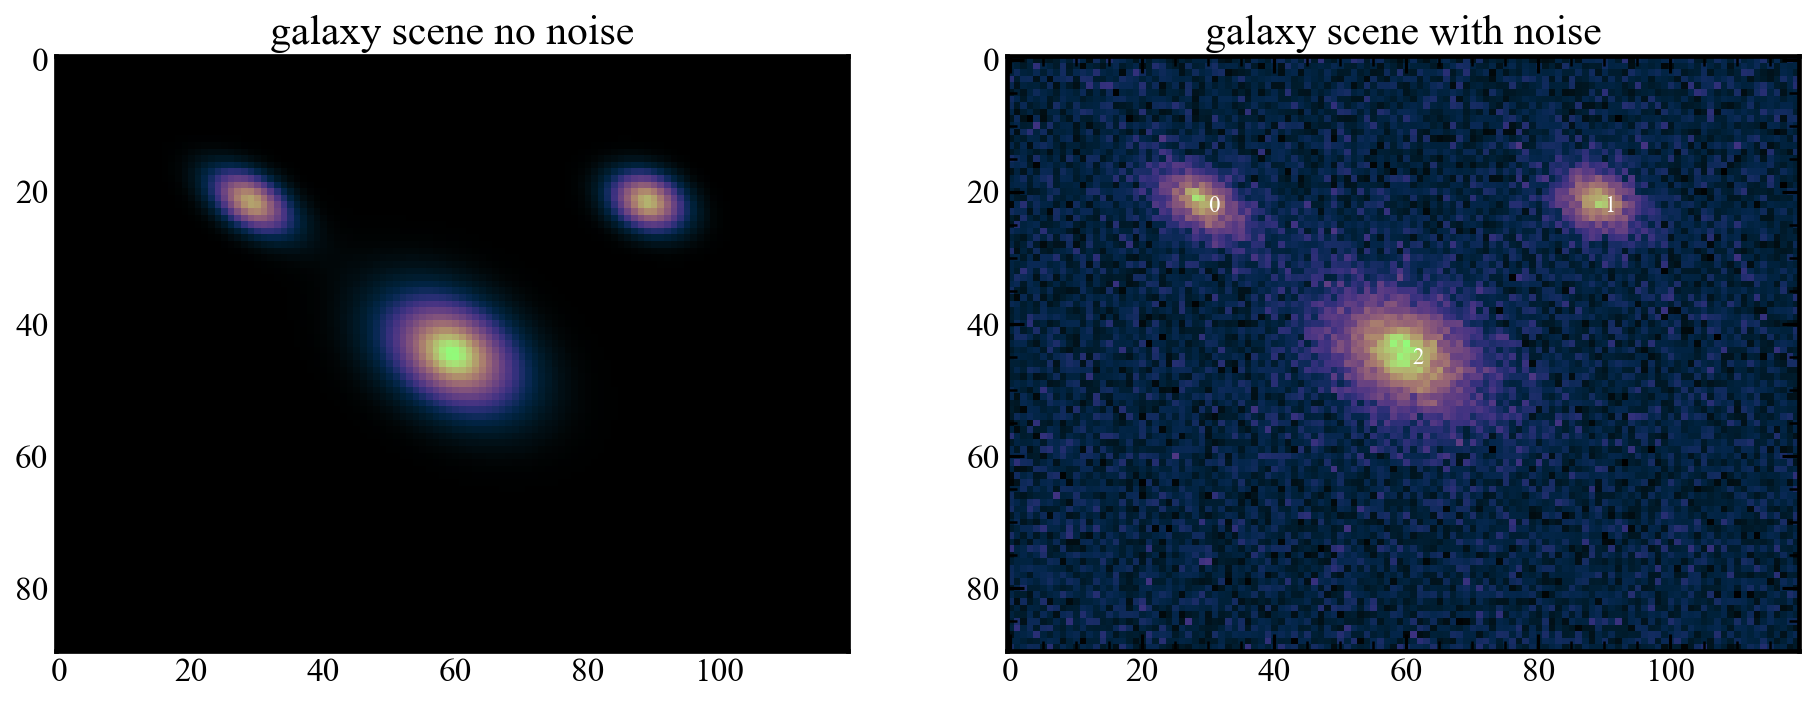

In [91]:
# Create figure for checking
# first display the clean image
fig = plt.figure(figsize=(15,7), dpi = 150)
plt.subplot(1,2,1)
plt.imshow(clean_gal, cmap = cmr.lilac)
plt.title('galaxy scene no noise',fontsize=20)

# now the mock observation
plt.subplot(1,2,2)
plt.imshow(gal_image, cmap = cmr.lilac)
plt.title('galaxy scene with noise',fontsize=20)
for i in range(n_sources):
    plt.text(centers[i][1],centers[i][0],str(i), c='white', fontsize=11)

In [ ]:
# create a dictionary to save data to disk
# TODO: this is single band so repeating entries for multi-band right now, fix this later
src_row = {
            'loc'   : [centers],
            'true_g': [clean_gal],
            'true_i': [clean_gal],
            'true_r': [clean_gal],
            'true_y': [clean_gal],
            'true_z': [clean_gal],
            'PSF_g' : [psf_image], 
            'PSF_i' : [psf_image], 
            'PSF_r' : [psf_image], 
            'PSF_y' : [psf_image], 
            'PSF_z' : [psf_image],
            # not sure yet how to get variances
            'var_g' : [clean_gal], 
            'var_i' : [clean_gal], 
            'var_r' : [clean_gal], 
            'var_y' : [clean_gal], 
            'var_z' : [clean_gal],
            'scene_g': [gal_image],
            'scene_i': [gal_image],
            'scene_r': [gal_image],
            'scene_y': [gal_image],
            'scene_z': [gal_image],
            }

cols = ['loc','true_g','true_i','true_r',
        'true_y','true_z','PSF_g', 'PSF_i', 
        'PSF_r', 'PSF_y', 'PSF_z',
        'var_g','var_i','var_r', 'var_y', 'var_z',
        'scene_g', 'scene_i','scene_r','scene_y','scene_z']

df = pd.DataFrame(src_row , columns = cols)

# save the data as a pickled pandas df
gal_name = 'mock_galaxy_src_' + str(n_sources) + '.pkl' 
df.to_pickle(gal_name)
print('data saved')

data saved
